# Basic Use of the SourcePathReceiver Object
This notebook demonstrates a basic workflow when using the SPR object for source estimation problems. It shows how to:

- Create the SPR object
- Evaluate the FRFs in the SPR object
- Estimate sources with the SPR object
- Evaluate the accuracy of the reconstructed responses, compared to the target responses

```{tip}
This example demonstrates the basic use of ForceFinder with the PowerSourcePathReceiver object type. All the SPR object types have a common look and feel. As a result, all the SPR object types use the same commands for object initialization and source estimation. The main differences in the API for the different SPR object types are the pre-implemented error metrics. 
```

In [1]:
import sdynpy as sdpy
import forcefinder as ff
import numpy as np
from scipy.signal.windows import tukey
from scipy.signal import butter, sosfiltfilt
import matplotlib.pyplot as plt

## Example Beam System
This example uses the beam system that was developed [here](sec:example_beam_system) for a simple force reconstruction problem. An image of the beam system is shown below, where the blue arrows (above the beam) are the response DOFs for the source estimation and the red arrows (below the beam) are the source DOFs. 

```{note}
The nodes are labeled 101-109 from left to right. The translating direction on the beam (vertical on the page) is Z+ and the rotating direction is RY+.
```

```{figure} images/beam_system_basic_usage.svg
:alt: Example Beam System
:align: center
```

The example data for this beam system is generated using the following process:

1. The SDynPy `System` object for the beam is imported
2. White noise excitation is created for the source DOFs on the beam
3. Time responses to the white noise excitation are computed (as SDynPy `TimeHistoryArray` objects) for the beam using the `time_integrate` method for the beam `System` object
4. Random measurement errors are added to the time response
5. The CPSD response is computed using the `cpsd` method for the SDynPy `TimeHistoryArray` object
6. The FRFs are computed for the beam system using the `frequency_response` method for the beam `System` object

In [2]:
beam_system = sdpy.System.load(r'./example_system/example_system.npz')

### Making the White Noise Excitation
The white noise is generated with a standard random number generator in NumPy. This time signal is then filtered to ~80% of the Nyquist frequency and a Tukey window is applied to reduce transient response issues at the signal start/stop. Sample time traces and frequency spectra for the excitation are shown in the plots below. 

In [3]:
sampling_rate = 1000 # Hz
time_duration = 60 # seconds
number_samples = sampling_rate*time_duration

time = np.arange(number_samples)/sampling_rate

In [4]:
sos_filter = butter(10, sampling_rate/2.56, btype='lowpass', 
                    output='sos', fs=sampling_rate)

raw_signal = np.random.randn(2, number_samples)
filtered_signal = sosfiltfilt(sos_filter, raw_signal)*tukey(number_samples, alpha=0.05)

sdynpy_signal = sdpy.time_history_array(time, filtered_signal, 
                    sdpy.coordinate_array(node=[103,108], direction=3)[...,np.newaxis])

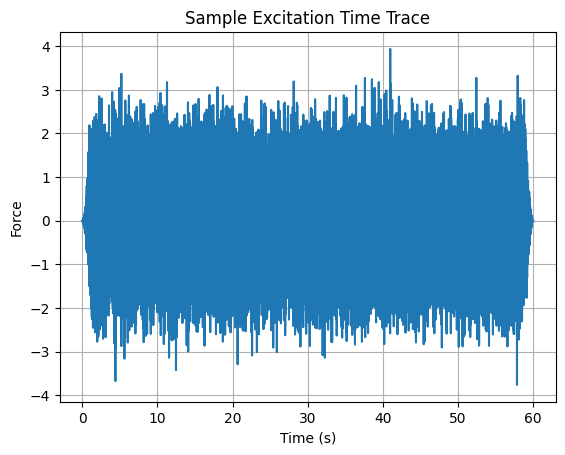

In [5]:
ax = sdynpy_signal[0].plot()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Force')
ax.set_title('Sample Excitation Time Trace')
ax.grid()

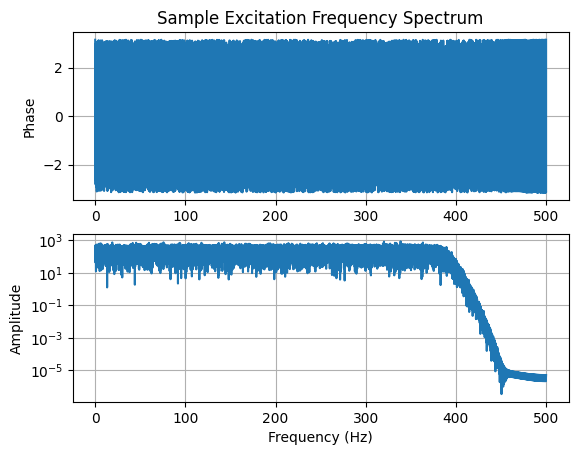

In [6]:
ax = sdynpy_signal[0].fft().plot()
ax[1].set_xlabel('Frequency (Hz)')
ax[0].set_title('Sample Excitation Frequency Spectrum')
ax[0].grid()
ax[1].grid()

### Computing the Time Response
The time responses are computed with time integration using an over sample factor of ten. The displacement derivative is set to two, meaning that the computed time responses are provided as accelerations. Random white noise is added to the computed response to simulate measurement errors. The amplitude of this noise was selected to result in a signal to noise ratio of ~20 dB.

```{note}
The `time_integrate` method computes time responses for all the DOFs in the beam.
```

In [7]:
time_response, forces = beam_system.time_integrate(sdynpy_signal, 
                                                   integration_oversample=10, 
                                                   displacement_derivative=2) 

noise_multiplier = time_response.rms()[...,np.newaxis]*(10**(-20/20))
time_response.ordinate += np.random.randn(time_response.shape[0], number_samples)*noise_multiplier

### Computing the CPSD Response and Truth Excitation
The CPSD response and truth excitation (for comparisons to the reconstructed forces) is computed using the `cpsd` method with the following signal processing settings. The time data is trimmed at the start and stop to avoid the using ring up and down from the windowing of the excitation signal in the CPSD processing. 

- Samples per frame: 1000 (frequency resolution of 1 Hz)
- Overlap: 50%
- Window: Hann 

In [8]:
cpsd_settings = {'samples_per_frame':1000,
                 'overlap':0.5,
                 'window':'hann'}

cpsd_force = forces.extract_elements_by_abscissa(1,59).cpsd(**cpsd_settings)

cpsd_response = time_response.extract_elements_by_abscissa(1,59).cpsd(**cpsd_settings)

### Computing the FRFs
The FRFs are computed using the frequency vector from the CPSD response and the reference `CoordinateArray` from the excitation signal. The displacement derivative is set to two, meaning that the FRFs are in accelerance format.  

In [9]:
frfs = beam_system.frequency_response(cpsd_response[0,0].abscissa,
                                      references=sdynpy_signal.response_coordinate, 
                                      displacement_derivative=2)

## Using the SPR Object
The example SPR object is created using the standard initialization function. The training response DOFs are explicitly defined to demonstrate the automatic sample splitting in ForceFinder.

```{note}
The training response DOFs were selected to demonstrate the sample splitting capabilities of ForceFinder and do not necessarily represent a good set of response DOFs for a source estimation problem.
```

```{note}
The frequency content of the SPR object is trimmed to the 1-500 Hz frequency range to avoid innocuous divide by zero warnings (in the error metrics) from the zero response at 0 Hz. 
```

In [10]:
training_response_dofs = sdpy.coordinate_array(node=[102,104,106,108], direction=3)

example_spr = ff.PowerSourcePathReceiver(frfs=frfs, target_response=cpsd_response,
                                training_response_coordinate=training_response_dofs)

example_spr.extract_elements_by_abscissa(min_abscissa=1)

'PowerSourcePathReceiver object with 2 reference coordinates, 18 target response coordinates, and 4 training response coordinates'

### Sample Splitting
Since the training response coordinate was explicitly defined, the target response DOFs (which are all the response DOFs on the beam) were split into a validation and training DOF set, as described [here](sec:sample_splitting). The sample splitting can be confirmed by reviewing the different DOF sets in the SPR object.

In [11]:
print('The target response DOFs are: ' + str(example_spr.target_response_coordinate.string_array()))

The target response DOFs are: ['101Z+' '101RY+' '102Z+' '102RY+' '103Z+' '103RY+' '104Z+' '104RY+'
 '105Z+' '105RY+' '106Z+' '106RY+' '107Z+' '107RY+' '108Z+' '108RY+'
 '109Z+' '109RY+']


In [12]:
print('The training response DOFs are: ' + str(example_spr.training_response_coordinate.string_array()))

The training response DOFs are: ['102Z+' '104Z+' '106Z+' '108Z+']


In [13]:
print('The validation response DOFs are: ' + str(example_spr.validation_response_coordinate.string_array()))

The validation response DOFs are: ['101Z+' '101RY+' '102RY+' '103Z+' '103RY+' '104RY+' '105Z+' '105RY+'
 '106RY+' '107Z+' '107RY+' '108RY+' '109Z+' '109RY+']


### Evaluating the FRFs
Most of the SPR object attributes are SDynPy objects, which means that SDynPy plotting functions can be used to evaluate and analyze the data. As such, it is simple to evaluate the conditioning of the training FRF matrix. There are three distinct segments of the code for reviewing the FRF condition, a sample breakdown of these segments for the `example_spr.training_frfs.plot_cond_num()` command is:

1. __<u>example_spr</u>.training_frfs.plot_cond_num()__ - `example_spr` indicates that we are looking at the data in the example SPR object.
2. __example_spr.<u>training_frfs</u>.plot_cond_num()__ - `training_frfs` is the [attribute](object_attribute_definitions) that returns the training FRFs as a SDynPy `TransferFunctionArray`.
3. __example_spr.training_frfs.<u>plot_cond_num()</u>__ - `plot_cond_num` is a method for the SDynPy `TransferFunctionArray`, which plots the (frequency dependent) condition number of the given FRFs.

This method chaining strategy is valid for any of the SPR object attributes, assuming that the method exists for the SDynPy object that is returned by the ForceFinder attribute.

```{warning}
In general, the SPR object attributes should be treated as read-only variables once the object is created. Technically, some attributes can be overwritten or modified, but this is considered bad practice. Further, some operations, which may seem logical for a SDynPy user will not work in ForceFinder. For example, the `spr_object.frfs.ordinate = data` command will not write or modify any data into the SPR object. 
```

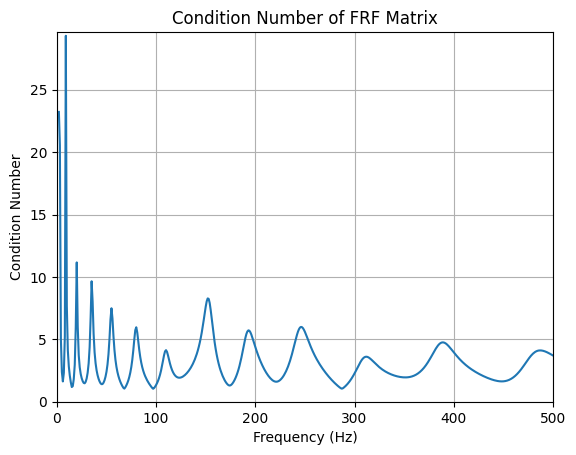

In [14]:
fig, ax = example_spr.training_frfs.plot_cond_num();
ax.set_xlim(left=0, right=500);

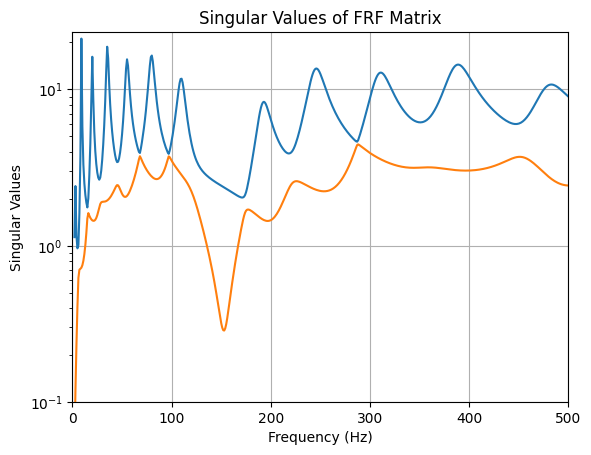

In [15]:
fig, ax = example_spr.training_frfs.plot_singular_values();
ax.set_xlim(left=0, right=500);
ax.set_ylim(bottom=1e-1);

## Estimating the Sources and Evaluating the Reconstructed Response Error
This section shows how to estimate the sources with a SPR object and evaluate the errors in the reconstructed response (sometimes referred to as on-board validation). In this case, the sources are estimated using the standard pseudo-inverse method, which is called with the `manual_inverse` method and setting the `method` kwarg to `standard`. 

In [16]:
example_spr.manual_inverse(method='standard')

'PowerSourcePathReceiver object with 2 reference coordinates, 18 target response coordinates, and 4 training response coordinates'

The errors in the reconstructed response for this example are evaluated with the [RMS ASD error](sec:rms_asd_error) metric for the training DOF set and validation DOF set by toggling the `channel_set` kwarg in the error method. As expected, the error is higher for the validation DOFs compared to the training DOFs. 

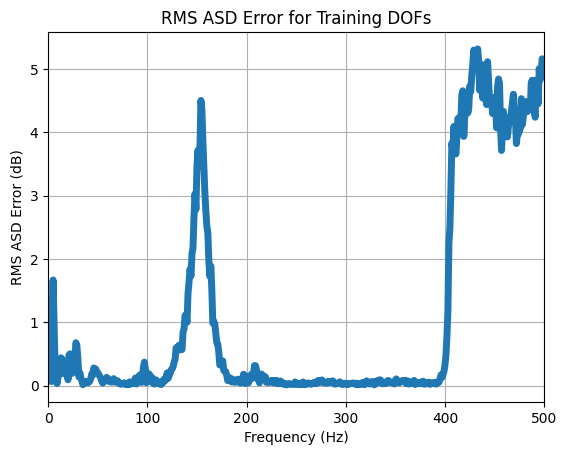

In [17]:
ax = example_spr.rms_asd_error(channel_set='training').plot(plot_kwargs={'linewidth':5})
ax.set_ylabel('RMS ASD Error (dB)')
ax.set_xlabel('Frequency (Hz)')
ax.set_title('RMS ASD Error for Training DOFs')
ax.grid()
ax.set_xlim(left=0, right=500);

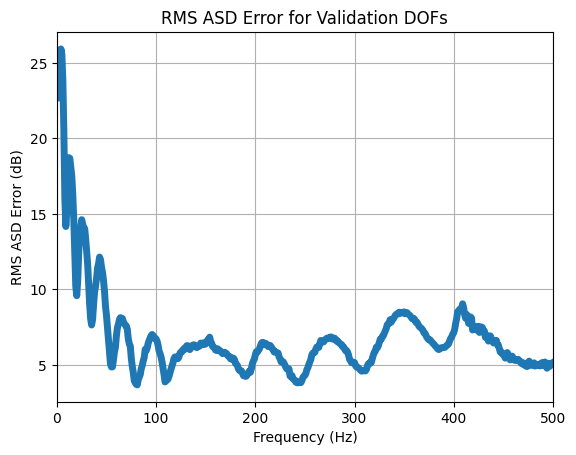

In [18]:
ax = example_spr.rms_asd_error(channel_set='validation').plot(plot_kwargs={'linewidth':5})
ax.set_ylabel('RMS ASD Error (dB)')
ax.set_xlabel('Frequency (Hz)')
ax.set_title('RMS ASD Error for Validation DOFs')
ax.grid()
ax.set_xlim(left=0, right=500);

The reconstructed response errors can also be evaluated on a DOF-DOF basis using the `error_summary` method where the target response is the black curve and the reconstructed responses are in blue. This plot shows the DOF-DOF comparison plots in the upper section, the lower left plot compares the PSD sums and the lower right plot is the RMS ASD error. Like the other error metrics, the `error_summary` can be shown for the different DOF sets using the `channel_set` kwarg. 

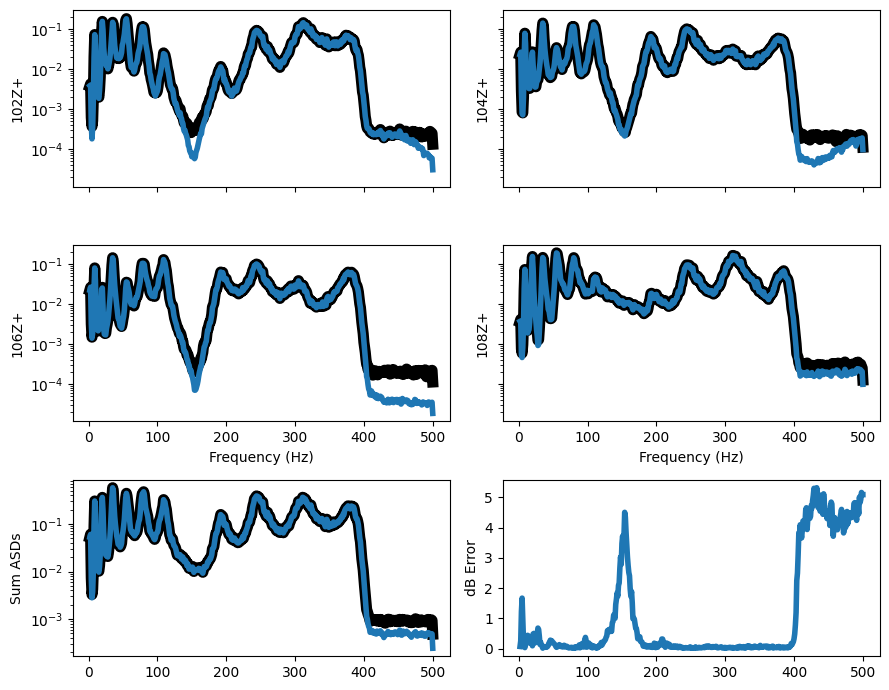

In [19]:
example_spr.error_summary(figure_kwargs={'figsize':(9,7)}, linewidth=4)

Lastly, it may be useful to compare the PSDs DOF-DOF, one at a time, which is easily accomplished with the `GUIPlot` tool in SDynPy. The code block below uses the `get_asd` method for SDynPy `PowerSpectralDensityArrays` to only plot the PSDs, but this is not necessary.

```{tip}
The `GUIPlot` tool will not directly plot in Jupyter Notebooks. The magic command `%matplotlib qt` must be used to open the `GUIPlot` tool in a separate window. Refer to IDE help documents to set the appropriate plotting backend.  
```

In [20]:
sdpy.GUIPlot(truth=example_spr.target_response.get_asd(),
             reconstructed=example_spr.reconstructed_target_response.get_asd())

```{figure} images/example_gui_plot.png
:alt: Example GUI Plot Window
:align: center
```

### Comparing the Estimated Sources to the Truth Sources
This section compares the PSDs for the estimated and truth sources, where the estimated sources are the `force` attribute of the SPR object. The plot below shows that the estimated sources are very accurate, except for an overestimation at high frequencies (where the truth sources are near zero) and an overestimation of the 103Z+ force at ~150 Hz. 

Both of these issues were indicated in the on-board validation. However, it is interesting to note that the reconstructed responses are lower than the training responses in the problematic frequency bands, which would imply that the sources were under predicted, which is the opposite of what actually happened.

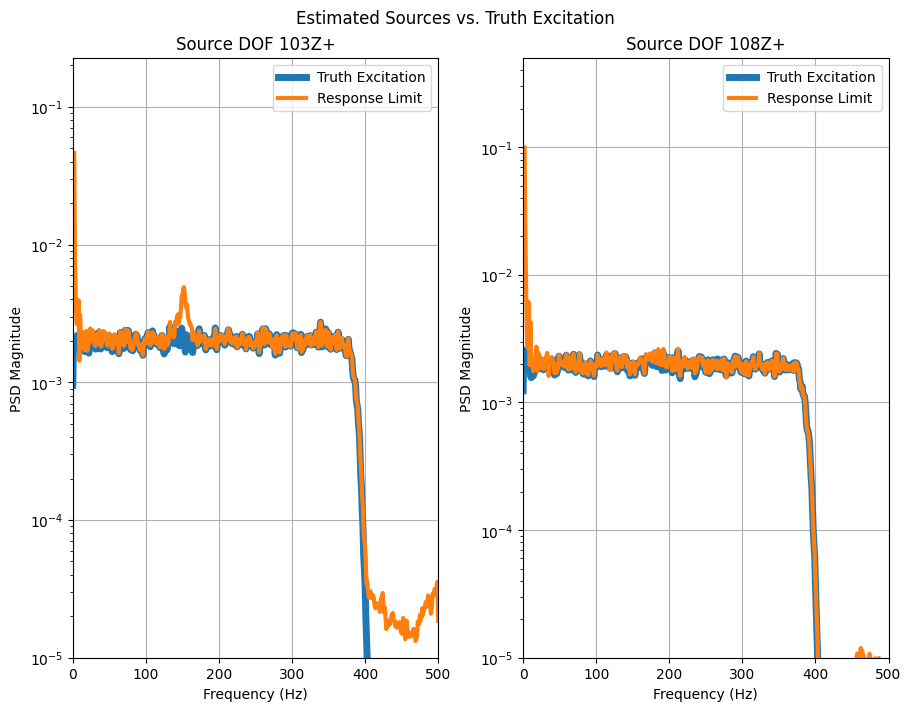

In [21]:
fig, ax = plt.subplots(1,2, layout='constrained', figsize=(9,7))
fig.suptitle('Estimated Sources vs. Truth Excitation')

ax[0].semilogy(cpsd_force[0,0].abscissa, np.abs(cpsd_force[0,0].ordinate),
               label='Truth Excitation', linewidth=5)
ax[0].semilogy(example_spr.abscissa, np.abs(example_spr.force[0,0].ordinate),
               label='Response Limit', linewidth=3)
ax[0].grid()
ax[0].legend()
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('PSD Magnitude')
ax[0].set_xlim(left=0, right=500)
ax[0].set_ylim(bottom=1e-5)
ax[0].set_title('Source DOF 103Z+');

ax[1].semilogy(cpsd_force[1,1].abscissa, np.abs(cpsd_force[1,1].ordinate),
               label='Truth Excitation', linewidth=5)
ax[1].semilogy(example_spr.abscissa, np.abs(example_spr.force[1,1].ordinate),
               label='Response Limit', linewidth=3)
ax[1].grid()
ax[1].legend()
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('PSD Magnitude')
ax[1].set_xlim(left=0, right=500)
ax[1].set_ylim(bottom=1e-5)
ax[1].set_title('Source DOF 108Z+');